### Import data from SQL database

In [4]:
# Import libraries
import numpy as np
import pandas as pd
import psycopg2
import matplotlib.pyplot as plt

%matplotlib inline

In [5]:
# create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

# Connect to local postgres version of mimic
con = psycopg2.connect(dbname=dbname, user=sqluser)
cur = con.cursor()

In [6]:
# SQL query (gets all_data view defined elsewhere)
query = \
"""
select * from all_data
"""

In [7]:
# Perform SQL query
cur.execute('SET search_path to ' + schema_name)
data = pd.read_sql_query(query,con)

# Preliminary statistics

In [8]:
data.shape

(58072, 43)

In [9]:
print 'Number of unique patient ids: {}'.format(len(data.subject_id.unique()))

Number of unique patient ids: 34000


In [24]:
print 'age\n',data.age.describe().ix[['mean', 'std']],'\n'
print 'age (<300)\n', data.loc[data.age<300].age.describe().ix[['mean', 'std']], '\n'
print 'sapsii\n', data.sapsii.describe().ix[['mean', 'std']],'\n'
print 'sofa\n', data.sofa.describe().ix[['mean', 'std']],'\n'
print data[['urea_n_min','urea_n_mean','urea_n_max',]].describe().ix[['mean', 'std']],'\n'
print data[['urea_n_min','urea_n_mean','urea_n_max',]].describe().ix[['mean', 'std']], '\n'
print data[['magnesium_max','albumin_min','calcium_min']].describe().ix[['mean', 'std']], '\n'
print data[['resprate_min','resprate_mean','resprate_max']].describe().ix[['mean', 'std']], '\n'
print data[['glucose_min','glucose_mean','glucose_max']].describe().ix[['mean', 'std']], '\n'
print data[['hr_min','hr_mean','hr_max']].describe().ix[['mean', 'std']], '\n'
print data[['sysbp_min','sysbp_mean','sysbp_max']].describe().ix[['mean', 'std']], '\n'
print data[['diasbp_min','diasbp_mean','diasbp_max']].describe().ix[['mean', 'std']], '\n'
print data[['temp_min','temp_mean','temp_max']].describe().ix[['mean', 'std']], '\n'
print data[['urine_min','urine_mean','urine_max']].describe().ix[['mean', 'std']]

age
mean    75.342952
std     53.858336
Name: age, dtype: float64 

age (<300)
mean    63.546693
std     16.042577
Name: age, dtype: float64 

sapsii
mean    36.884161
std     14.472444
Name: sapsii, dtype: float64 

sofa
mean    4.552934
std     3.247176
Name: sofa, dtype: float64 

      urea_n_min  urea_n_mean  urea_n_max
mean   16.445421    27.288461   42.126805
std    13.301107    18.889476   31.139652 

      urea_n_min  urea_n_mean  urea_n_max
mean   16.445421    27.288461   42.126805
std    13.301107    18.889476   31.139652 

      magnesium_max  albumin_min  calcium_min
mean       2.501220     2.794285     7.671528
std        1.012606     0.756592     0.866263 

      resprate_min  resprate_mean  resprate_max
mean      9.784419      19.375970     32.970443
std       3.725866       3.541496      9.069465 

      glucose_min  glucose_mean  glucose_max
mean    86.944955    137.754290   270.786049
std     30.178530     86.816148  5956.989526 

         hr_min    hr_mean      hr_m

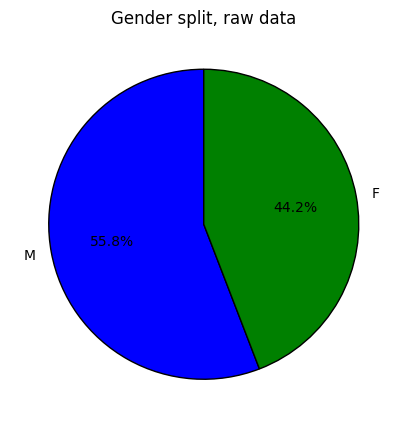

In [21]:
fig = plt.figure(figsize=(5,5))
data.gender.value_counts().plot.pie(startangle = 90, autopct='%1.1f%%')
plt.title('Gender split, raw data')
plt.ylabel('')
fig.savefig('figures/raw_gender.png')

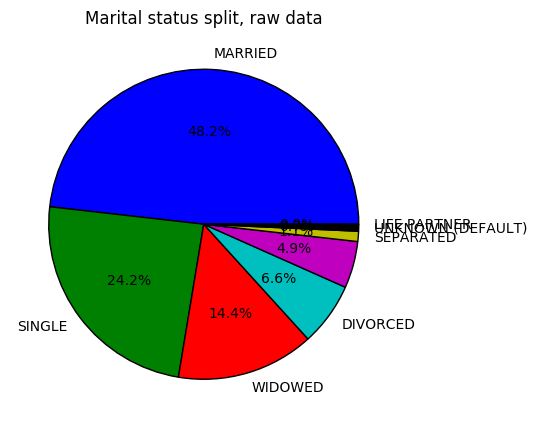

In [22]:
fig = plt.figure(figsize=(5,5))
data.marital_status.value_counts().plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Marital status split, raw data')
plt.ylabel('')
fig.savefig('figures/raw_marital.png')

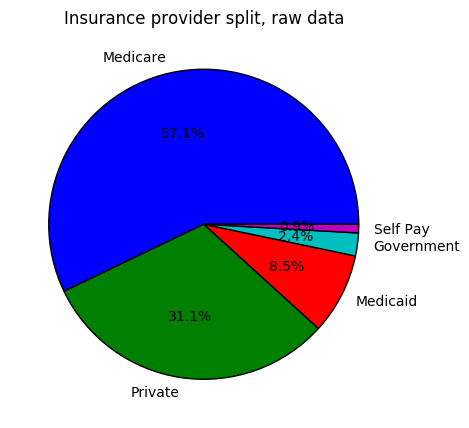

In [23]:
fig = plt.figure(figsize=(5,5))
data.insurance.value_counts().plot.pie(startangle = 0, autopct='%1.1f%%')
plt.title('Insurance provider split, raw data')
plt.ylabel('')
fig.savefig('figures/raw_insurance.png')

In [24]:
np.sum(data.isnull())

subject_id            0
hadm_id               0
admittime             0
dischtime             0
deathtime         48952
first_careunit        0
last_careunit         0
age                   0
gender                0
marital_status        0
insurance             0
urea_n_min           46
urea_n_max           46
urea_n_mean          46
platelets_min        63
platelets_max        63
platelets_mean       63
magnesium_max       451
albumin_min       16815
calcium_min        1757
resprate_min         15
resprate_max         15
resprate_mean        15
glucose_min         354
glucose_max         354
glucose_mean        354
hr_min                2
hr_max                2
hr_mean               2
sysbp_min             8
sysbp_max             8
sysbp_mean            8
diasbp_min            8
diasbp_max            8
diasbp_mean           8
temp_min             88
temp_max             88
temp_mean            88
sapsii                0
sofa                  0
urine_min            11
urine_mean      

### Extract readmission time information

In [25]:
# calculate time delta between subsequent readmissions of the same patient 
data['readmit_dt'] = np.zeros(data.shape[0])
data['next_readmit_dt'] = np.zeros(data.shape[0])
data['readmit_last_careunit'] = None

for idx in np.arange(1,data.shape[0]):
    if data.subject_id[idx] == data.subject_id[idx - 1]:     
        prev_disch = data.dischtime[idx-1]
        curr_adm = data.admittime[idx]
        dt = curr_adm - prev_disch
        dt_hrs_calc = np.round(dt.value/3600.0/1e9,2)

#         data.set_value(idx,'adm_num',data['adm_num'][idx-1] + 1) 
        data.set_value(idx,'readmit_dt',dt_hrs_calc)
        data.set_value(idx-1,'next_readmit_dt',dt_hrs_calc)
        data.set_value(idx,'readmit_last_careunit',data['last_careunit'][idx-1]) 


In [26]:
data.shape

(58072, 46)

### Clean up missing or invalid values

In [27]:
data = data.drop(['urine_min','urine_mean','urine_max'], axis = 1) #Too noisy
data = data[data.readmit_dt >= 0] #Ignore cases where readmit_dt < 0, which result from duplicate records. 
data = data.ix[(data.deathtime.isnull())] #Remove cases where the patient died during stay
data = data.drop(['deathtime'], axis = 1) # Important to drop before dropna otherwise most of the data is lost
data = data.dropna(subset=data.keys()[:-1]).reset_index(drop = True) # Ignore NaN values in readmit_last_careunit

In [28]:
print 'Dataframe shape after removal of invalid values: \n{}'.format(data.shape)

Dataframe shape after removal of invalid values: 
(21732, 42)


### Define time threshold and corresponding labels

In [29]:
# Define threshold in hours
threshold = 30*24

In [30]:
# Define label column based on threshold
data['future_readmit'] = None
data['future_readmit'] = ['No' if dt == 0.0 else 'Yes' if dt<=threshold else 'No' for dt in data.next_readmit_dt]

In [31]:
print 'Value counts:'
print data.future_readmit.value_counts()
print '\nValue proportions:'
print data.future_readmit.value_counts()/data.shape[0]

Value counts:
No     18706
Yes     3026
Name: future_readmit, dtype: int64

Value proportions:
No     0.860758
Yes    0.139242
Name: future_readmit, dtype: float64


### Focus on admittions to the MICU:

In [32]:
MICU_admits_clean = data.loc[data.first_careunit == 'MICU']

A quick look at the label distribution:

In [33]:
print 'Value counts:'
print MICU_admits_clean.future_readmit.value_counts()
print '\nValue proportions:'
print MICU_admits_clean.future_readmit.value_counts()/MICU_admits_clean.shape[0]

Value counts:
No     7611
Yes    1183
Name: future_readmit, dtype: int64

Value proportions:
No     0.865476
Yes    0.134524
Name: future_readmit, dtype: float64


In [34]:
# Save clean dataset to csv
MICU_admits_clean.to_csv('MICU_admits_clean.csv', index=False)